## 필수과제1
- 최소 R2 기준으로 0.85 이상을 올리고 인증해야 합니다.
- 0.85 넘지 않으면, 이 부분은 과제를 수행하지 않은 것
- 0.85 꼭 넘겨야 한다.
---
- 무엇보다 전처리를 한 후에 왜 이렇게 전처리를 했고, 그 전처리 방식을 정리하고, 시각적으로도 표현할 수 있게 잘 정리도 부탁드립니다.

In [17]:
from sklearn.datasets import fetch_california_housing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import fetch_california_housing
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.cluster import KMeans

In [18]:
california=fetch_california_housing()

X = california.data
y = california.target

df = pd.DataFrame(X,columns = california.feature_names)
df['MedHouseVal'] = y

In [19]:
df

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847


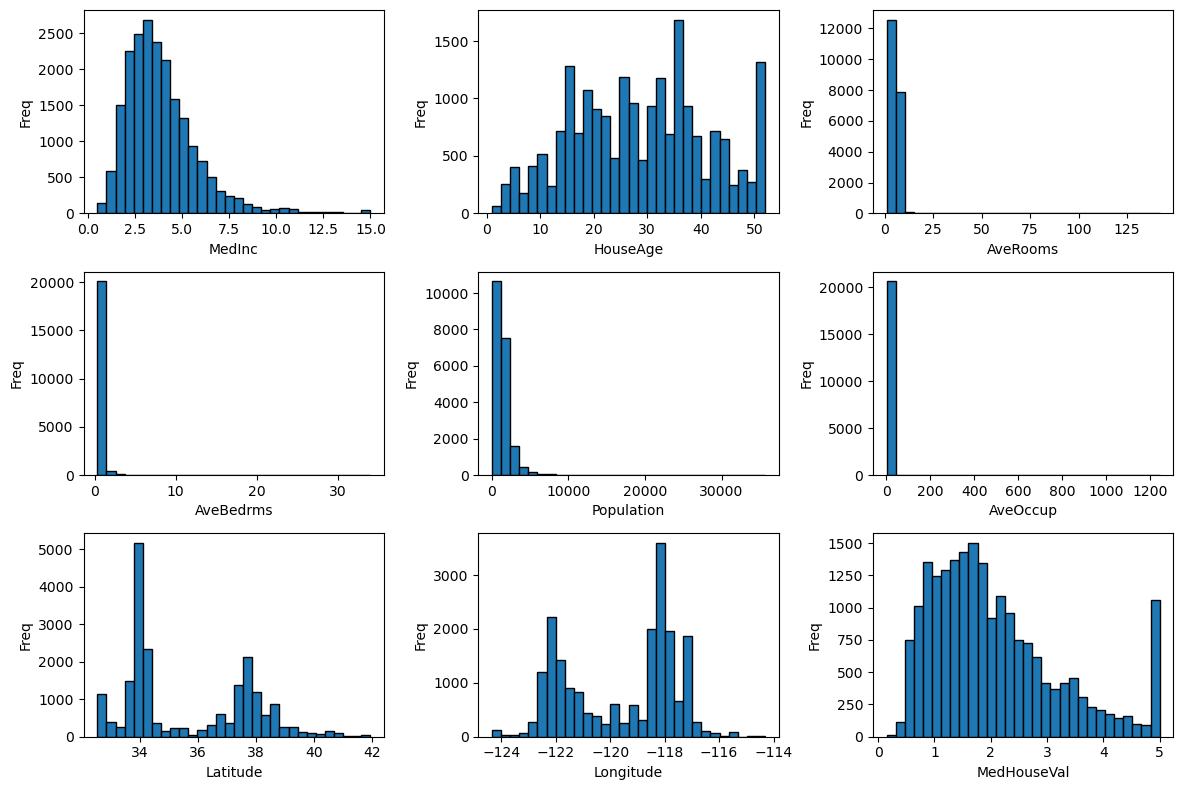

In [20]:
fig, axes = plt.subplots(3,3, figsize=(12,8))

for i, col in enumerate(df.columns):
    ax = axes[i//3, i%3]
    ax.hist(df[col], bins=30, edgecolor='k')
    ax.set_xlabel(col)
    ax.set_ylabel('Freq')

plt.tight_layout()
plt.show()

In [21]:
# AveRooms, AveBedrms, Population, AveOccup 는 왜도가 양수이다. 
# 로그변환을 사용하여 왜도를 줄이고, 정규분포로 조정해야 한다.

df['AveRooms'] = np.log1p(df['AveRooms'])
df['AveBedrms'] = np.log1p(df['AveBedrms'])
df['Population'] = np.log1p(df['Population'])
df['AveOccup'] = np.log1p(df['AveOccup'])

In [22]:
def lr_rg_test (X, y, test_size=0.2, random_state=1):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)  # Note: Use `transform`, not `fit_transform`, for test data

    lr_rg = LinearRegression()
    lr_rg.fit(X_train_scaled, y_train)

    lr_pred = lr_rg.predict(X_test_scaled)

    mse = mean_squared_error(y_test, lr_pred)
    r2 = r2_score(y_test, lr_pred)

    print(f'MSE : {mse}')
    print(f'R2 : {r2}')

    return {'MSE': mse, 'R2': r2}

In [23]:
X = df[['MedInc']]

lr_rg_test(X, y, test_size=0.2, random_state=1)

MSE : 0.692692969609108
R2 : 0.47190835934467723


{'MSE': 0.692692969609108, 'R2': 0.47190835934467723}

In [24]:
geo_ftr = ['Latitude','Longitude']
geo_data = df[geo_ftr]

scaler = StandardScaler()
geo_data_scaled = scaler.fit_transform(geo_data)

In [25]:
km = KMeans(n_clusters=4, random_state=1)
df['cluster'] = km.fit_predict(geo_data_scaled)

avg_price = df.groupby('cluster')['MedHouseVal'].mean()
avg_price

cluster
0    2.304260
1    2.086802
2    1.216743
3    1.772640
Name: MedHouseVal, dtype: float64

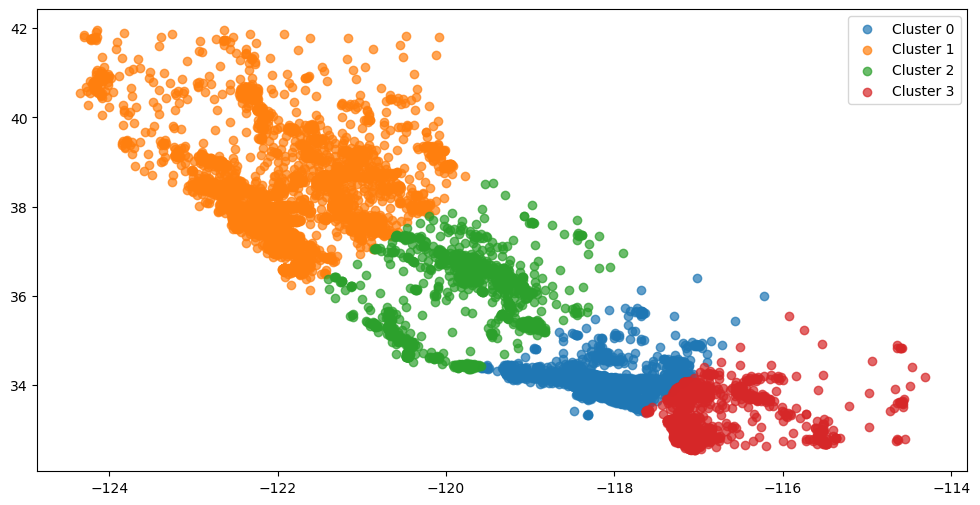

In [26]:
plt.figure(figsize=(12,6))
for i in range(4):
    cluster_data = df[df['cluster']==i]
    plt.scatter(cluster_data['Longitude'], cluster_data['Latitude'], label=f'Cluster {i}', alpha=0.7)
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


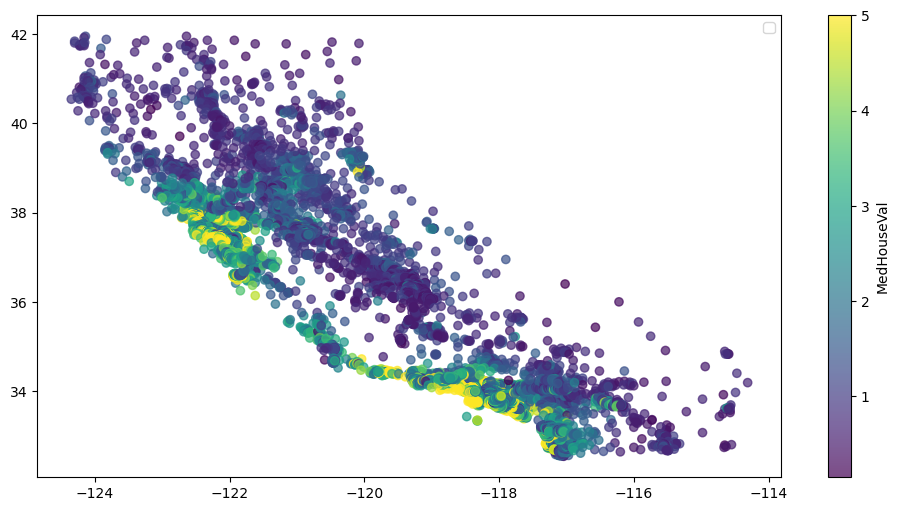

In [27]:
plt.figure(figsize=(12,6))
plot = plt.scatter(df['Longitude'], df['Latitude'], c=df['MedHouseVal'], cmap='viridis', alpha=0.7)
plt.colorbar(plot, label='MedHouseVal')
plt.legend()
plt.show()

In [28]:
def label_expensive(row):
    cluster_avg = avg_price[row['cluster']]
    return 1 if row['MedHouseVal'] > cluster_avg else 0

df['PriceLabel'] = df.apply(label_expensive, axis=1)

In [29]:
df['PriceLabel'].value_counts()

PriceLabel
0    12645
1     7995
Name: count, dtype: int64

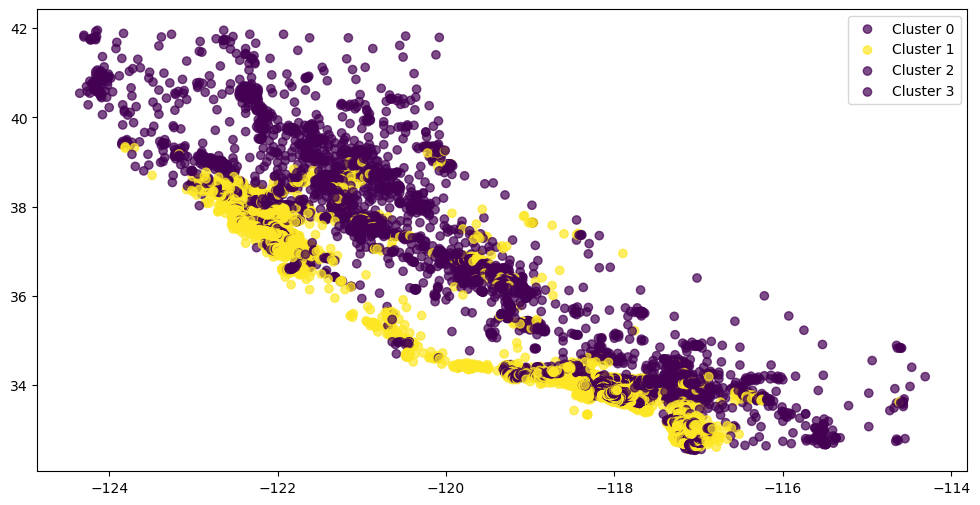

In [30]:
plt.figure(figsize=(12,6))
for i in range(4):
    cluster_data = df[df['cluster']==i]
    plt.scatter(cluster_data['Longitude'], cluster_data['Latitude'], c=cluster_data['PriceLabel'], label=f'Cluster {i}', alpha=0.7)
plt.legend()
plt.show()

In [31]:
ftr1 = ['MedInc','PriceLabel']
X = df[ftr1]
y = df['MedHouseVal']

lr_rg_test(X, y, test_size=0.2, random_state=1)

MSE : 0.38283930482365985
R2 : 0.7081329745474993


{'MSE': 0.38283930482365985, 'R2': 0.7081329745474993}

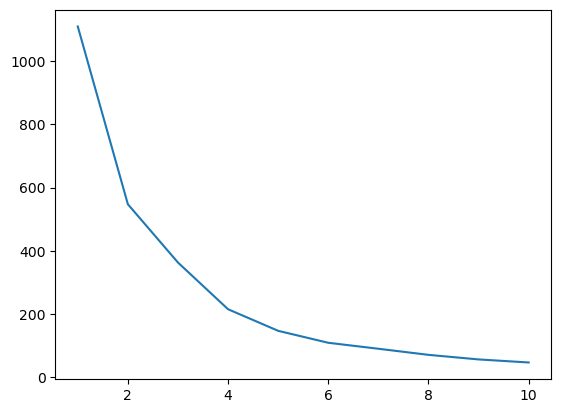

In [32]:
ave_rooms = df[['AveRooms']]

wcss = []
for i in range(1,11):
    km = KMeans(n_clusters=i, random_state=1)
    km.fit(ave_rooms)
    wcss.append(km.inertia_)

plt.plot(range(1,11), wcss)
plt.show()

In [33]:
km = KMeans(n_clusters=4, random_state=1)
df['cluster_room'] = km.fit_predict(ave_rooms)

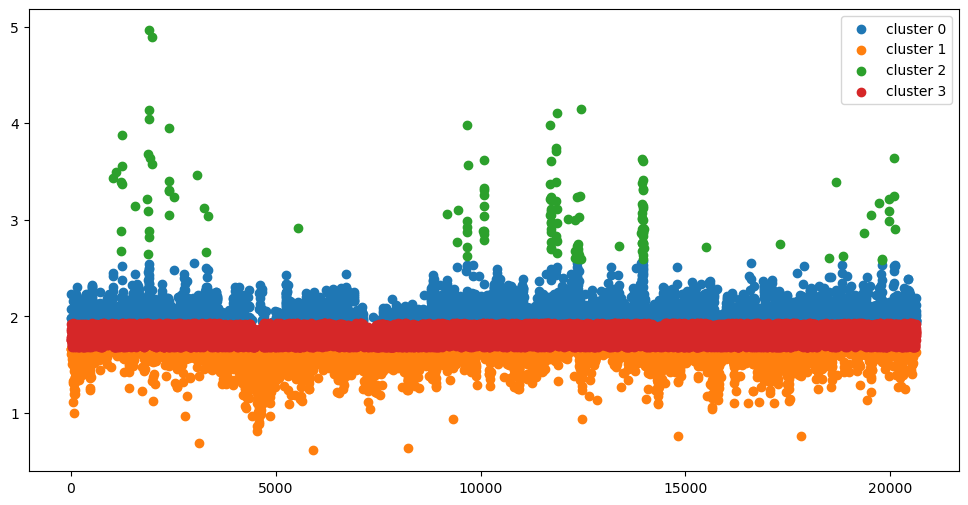

cluster_room
3    9981
0    5865
1    4650
2     144
Name: count, dtype: int64

In [34]:
plt.figure(figsize=(12,6))
for i in range(4):
    cluster_data = df[df['cluster_room'] == i]
    plt.scatter(cluster_data.index, cluster_data['AveRooms'], label=f'cluster {i}')

plt.legend()
plt.show()

df['cluster_room'].value_counts()

In [35]:
ftr2 = ['MedInc','PriceLabel', 'cluster_room']
X = df[ftr2]
y = df['MedHouseVal']

lr_rg_test(X, y, test_size=0.2, random_state=1)

MSE : 0.3828364664194535
R2 : 0.7081351384752421


{'MSE': 0.3828364664194535, 'R2': 0.7081351384752421}

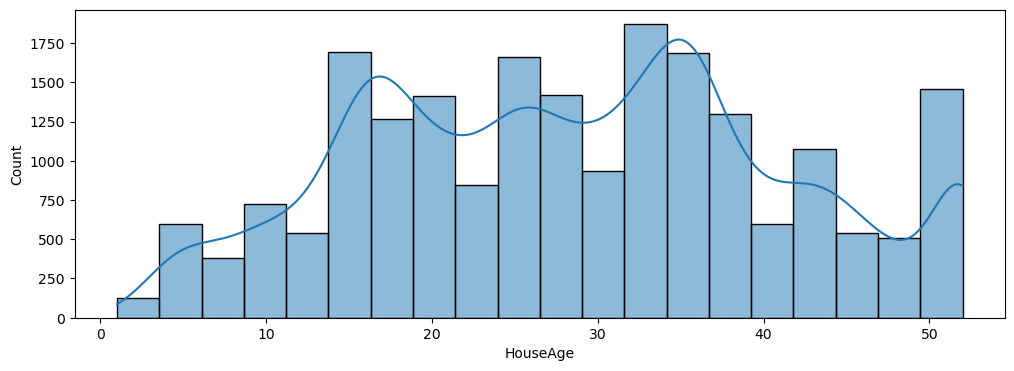

In [36]:
plt.figure(figsize=(12,4))
sns.histplot(data=df, x='HouseAge', kde=True, bins=20)
plt.show()

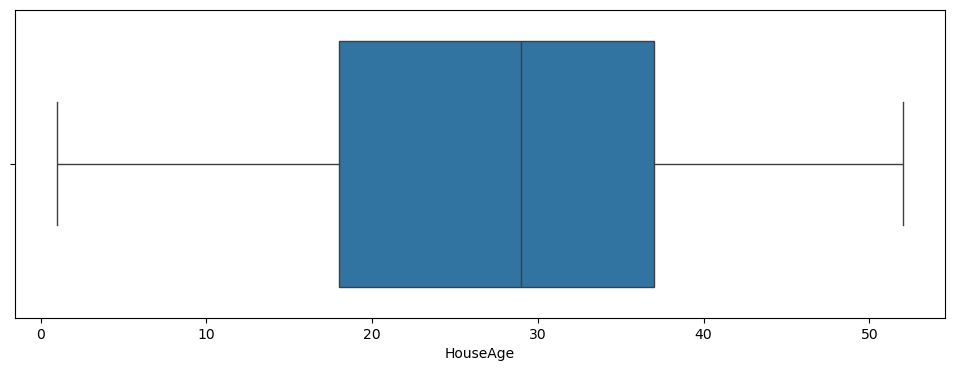

count    20640.000000
mean        28.639486
std         12.585558
min          1.000000
25%         18.000000
50%         29.000000
75%         37.000000
max         52.000000
Name: HouseAge, dtype: float64

In [37]:
plt.figure(figsize=(12,4))
sns.boxplot(data=df, x='HouseAge')
plt.show()

df['HouseAge'].describe()


In [38]:
df['HouseAge_cat'] = pd.cut(df['HouseAge'], bins=[0, 18, 29, 37, 52], labels=['1', '2', '3', '4'])
df['HouseAge_cat'].value_counts()

HouseAge_cat
2    5343
1    5326
3    5026
4    4945
Name: count, dtype: int64

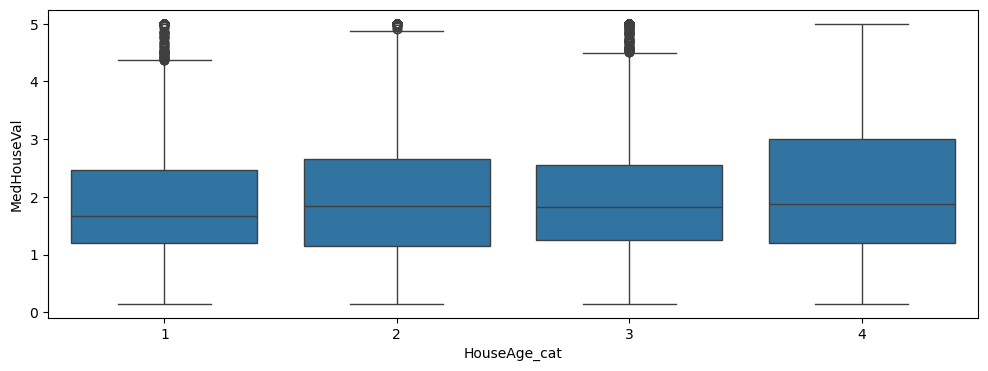

In [39]:
plt.figure(figsize=(12,4))
sns.boxplot(data=df, x='HouseAge_cat', y='MedHouseVal')
plt.show()

In [49]:
ftr3 = ['MedInc','PriceLabel', 'cluster_room', 'HouseAge_cat']
X = df[ftr3]
y = df['MedHouseVal']

lr_rg_test(X, y, test_size=0.2, random_state=1)

MSE : 0.363216904485696
R2 : 0.7230925974146385


{'MSE': 0.363216904485696, 'R2': 0.7230925974146385}

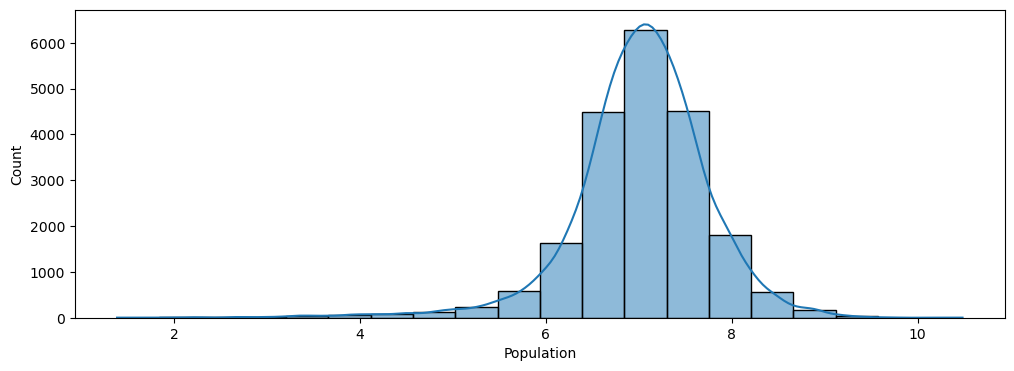

In [44]:
plt.figure(figsize=(12,4))
sns.histplot(data=df, x='Population', kde=True, bins=20)
plt.show()

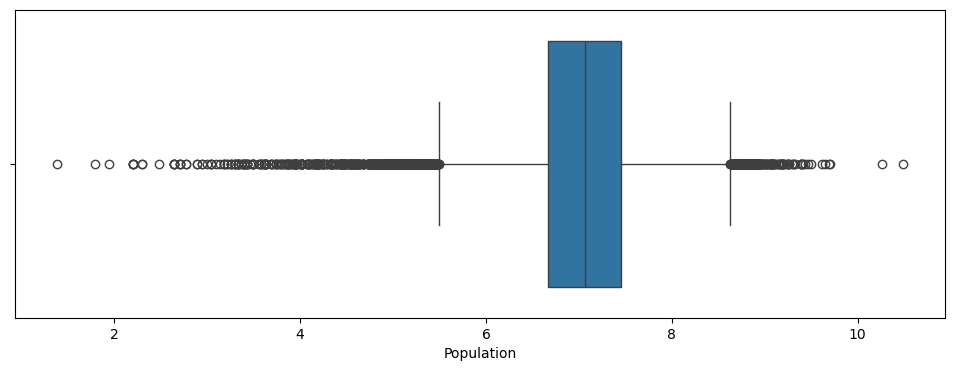

count    20640.000000
mean         7.025503
std          0.736238
min          1.386294
25%          6.669498
50%          7.062192
75%          7.453562
max         10.482430
Name: Population, dtype: float64

In [46]:
plt.figure(figsize=(12,4))
sns.boxplot(data=df, x='Population')
plt.show()

df['Population'].describe()


In [47]:
df['Population_cat'] = pd.cut(df['Population'], bins=[1, 6.6, 7, 7.4, 11], labels=['1', '2', '3', '4'])
df['Population_cat'].value_counts()

Population_cat
4    5786
3    5434
2    4969
1    4451
Name: count, dtype: int64

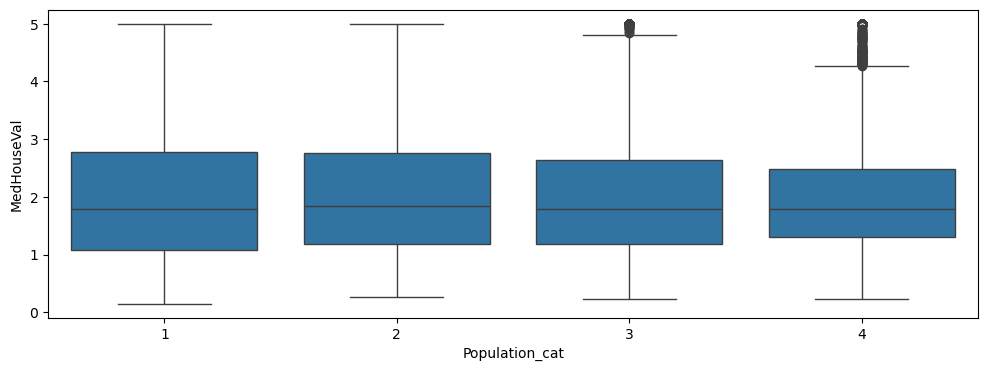

In [48]:
plt.figure(figsize=(12,4))
sns.boxplot(data=df, x='Population_cat', y='MedHouseVal')
plt.show()

In [50]:
ftr4 = ['MedInc','PriceLabel', 'cluster_room', 'HouseAge_cat', 'Population_cat']
X = df[ftr4]
y = df['MedHouseVal']

lr_rg_test(X, y, test_size=0.2, random_state=1)

MSE : 0.36215183703784243
R2 : 0.7239045779610311


{'MSE': 0.36215183703784243, 'R2': 0.7239045779610311}

In [76]:
# ftr5 

X = df.drop('MedHouseVal', axis=1)
y = df['MedHouseVal']

lr_rg_test(X, y, test_size=0.2, random_state=1)

MSE : 0.2837398826012235
R2 : 0.783683873380749


{'MSE': 0.2837398826012235, 'R2': 0.783683873380749}

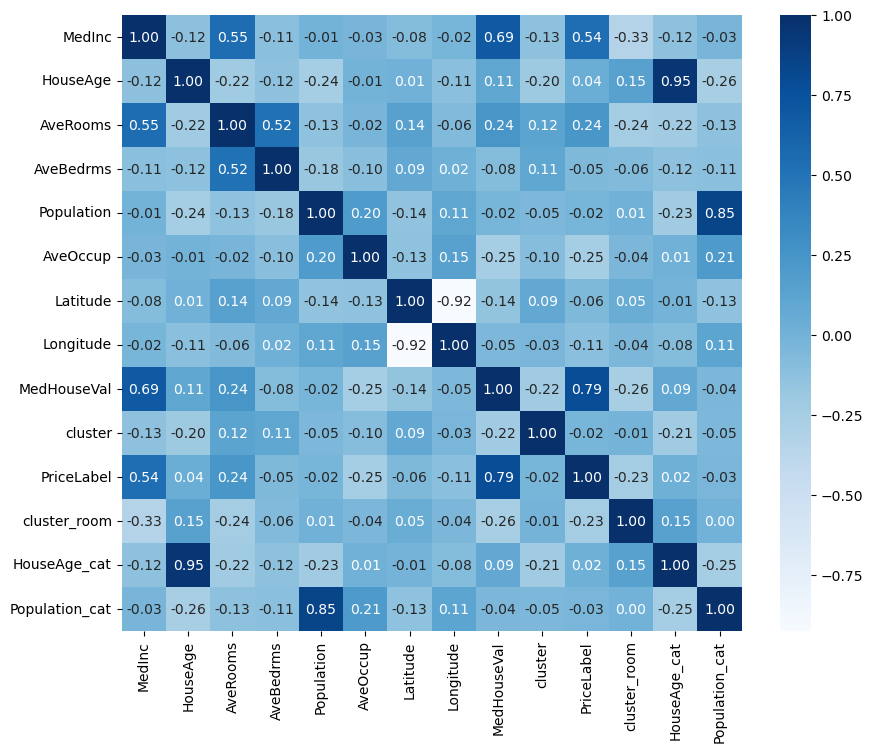

In [68]:
plt.figure(figsize=(10, 8))
sns.heatmap(data=df.corr(), annot=True, cmap='Blues', fmt='.2f')
plt.show()

In [ ]:
# 모델 변환

from sklearn.ensemble import RandomForestRegressor

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

rf_rg = RandomForestRegressor(random_state=1)
rf_rg.fit(X_train, y_train)

rf_pred = rf_rg.predict(X_test)

mse = mean_squared_error(y_test, rf_pred)
r2 = r2_score(y_test, rf_pred)

print(f'MSE : {mse}')
print(f'R2 : {r2}')